# Swing-Up Cart-Pole with DQN (Deep Q-learning)

In [2]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3 import DQN

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

from collections import defaultdict

Training Call back to tell

Number of timesteps / Episodes

Best Reward / Last Reward per episode / Mean Reward last 10 episode / Delta mean Reward

In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1, reward_function: str = None, file_name: str = None):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "Best Models", reward_function, file_name)
        self.best_reward = -np.inf
        self.prev_mean_reward = 0.0

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "episodes")
          if len(x) > 0:
              # Mean training reward over the last 10 episodes
              last_ep = x[-1]
              last_reward = y[-1] 
              mean_reward = np.mean(y[-10:])
              delta_mearn_reward = mean_reward - self.prev_mean_reward
              self.prev_mean_reward = mean_reward
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps} - Ep: {last_ep}")
                print(f"Best reward: {self.best_reward:.2f} - Last reward per episode: {last_reward:.2f} - Mean reward last 10 episode: {mean_reward:.2f} - Delta mean: {delta_mearn_reward:.2f}")

              # New best model, you could save the agent here
              if last_reward > self.best_reward:
                  self.best_reward = last_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

## Training Phase

In [ ]:
def make_env(env_id: str, rank: int, seed: int = 0, render_mode = None, action_type = "Box", observation_type = "Continous", reward_function = "Absolute", task = "InvertedCartPole"):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = gym.make(env_id, render_mode=render_mode, action_type = action_type, observation_type = observation_type, reward_function = reward_function, task = task) #gym.make(env_id, render_mode="human")
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    # log_dir = "tmpa/"
    # os.makedirs(log_dir, exist_ok=True)

    env_id = "CartPole-v1"
    num_cpu = 3  # Number of processes to use
    total_timesteps=1_000_000 #
    Algorithm_name = 'DQN'
    reward_function = "Sparse"

    log_dir = os.path.join('Training', 'Save Models', Algorithm_name)
    os.makedirs(log_dir, exist_ok=True)

    # Create the vectorized environment
    vec_env = SubprocVecEnv([make_env(env_id, i, reward_function=reward_function, action_type='Discrete') for i in range(num_cpu)])
    vec_env = VecMonitor(vec_env, log_dir)
    # env = gym.make(env_id)
    # print(vec_env)

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, reward_function=reward_function, file_name='{}_ip_{}_{}'.format(Algorithm_name, num_cpu, total_timesteps))


    model = DQN("MlpPolicy", vec_env, verbose=0)
    model.learn(total_timesteps=total_timesteps, progress_bar=True, callback=callback) #250000 callback=callback

### Graph: Display Episode Rewards for PPO algorithm / Reward Function

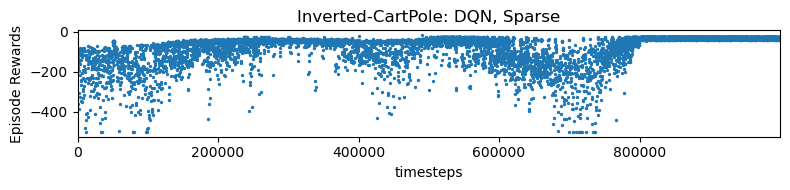

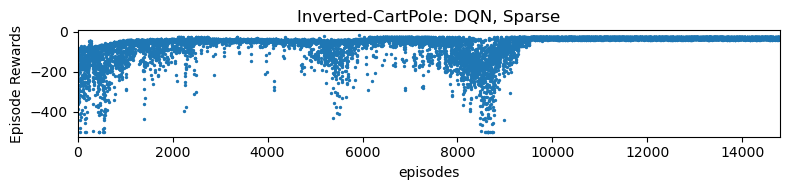

In [4]:
plot_results([log_dir], total_timesteps, results_plotter.X_TIMESTEPS, "Inverted-CartPole: {}, {}".format(Algorithm_name, reward_function))
plt.show()
plot_results([log_dir], total_timesteps, results_plotter.X_EPISODES, "Inverted-CartPole: {}, {}".format(Algorithm_name, reward_function))
plt.show()

Save model

In [3]:
# the saved model does not contain the replay buffer
DQN_Path = os.path.join('Training', 'Save Models','DQN', 'Best Models', 'Absolute', 'DQN_ip_3_400000.zip')
loaded_model = DQN.load(DQN_Path)
print(f"The loaded_model has {loaded_model} transitions in its buffer")

The loaded_model has <stable_baselines3.dqn.dqn.DQN object at 0x000001B9FFC93C40> transitions in its buffer


## Testing Phase

In [ ]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='human', action_type = "Discrete", observation_type = "Continous", reward_function = "Absolute", task = "InvertedCartPole")
obs_ls = []
episodes = 100

pole_pos_np_min = defaultdict(lambda: 0)
pole_pos_np_max = defaultdict(lambda: 0)
avg_error_pole_pos_dict = defaultdict(lambda: 0)

cart_pos_np_min = defaultdict(lambda: 0)
cart_pos_np_max = defaultdict(lambda: 0)
avg_error_cart_pos_dict = defaultdict(lambda: 0)

pole_vel_np_min = defaultdict(lambda: 0)
pole_vel_np_max = defaultdict(lambda: 0)
avg_error_pole_vel_dict = defaultdict(lambda: 0)

cart_vel_np_min = defaultdict(lambda: 0)
cart_vel_np_max = defaultdict(lambda: 0)
avg_error_cart_vel_dict = defaultdict(lambda: 0)

N_pos_dict = defaultdict(lambda: 0)
N_vel_dict = defaultdict(lambda: 0)

for episodes in range(1, episodes+1):
    obs, _ = env.reset()
    done = False
    score = 0
    time_step = 0

    while not done:
        env.render()
        action = loaded_model.predict(obs)
        obs, reward, done, truncated, info = env.step(action[0])
        score += reward
        obs_ls.append(obs[2])

        time_step += 1

        cart_pos = obs[0]
        cart_vel = obs[1]
        pole_pos = obs[2]
        pole_vel = obs[3]

        if cart_pos >= cart_pos_np_max[time_step - 1]:
            cart_pos_np_max[time_step - 1] = cart_pos
        if cart_pos <= cart_pos_np_min[time_step - 1]:
            cart_pos_np_min[time_step - 1] = cart_pos

        if pole_pos >= pole_pos_np_max[time_step - 1]:
            pole_pos_np_max[time_step - 1] = pole_pos
        if pole_pos <= pole_pos_np_min[time_step - 1]:
            pole_pos_np_min[time_step - 1] = pole_pos

        N_pos_dict[time_step - 1] += 1
        avg_error_cart_pos_dict[time_step - 1] = avg_error_cart_pos_dict[time_step - 1] + (cart_pos - avg_error_cart_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]
        avg_error_pole_pos_dict[time_step - 1] = avg_error_pole_pos_dict[time_step - 1] + (pole_pos - avg_error_pole_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]

        if cart_vel >= cart_vel_np_max[time_step - 1]:
            cart_vel_np_max[time_step - 1] = cart_vel
        if cart_vel <= cart_vel_np_min[time_step - 1]:
            cart_vel_np_min[time_step - 1] = cart_vel

        if pole_vel >= pole_vel_np_max[time_step - 1]:
            pole_vel_np_max[time_step - 1] = pole_vel
        if pole_vel <= pole_vel_np_min[time_step - 1]:
            pole_vel_np_min[time_step - 1] = pole_vel

        N_vel_dict[time_step - 1] += 1
        avg_error_cart_vel_dict[time_step - 1] = avg_error_cart_vel_dict[time_step - 1] + (cart_vel - avg_error_cart_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]
        avg_error_pole_vel_dict[time_step - 1] = avg_error_pole_vel_dict[time_step - 1] + (pole_vel - avg_error_pole_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]
        
    # print('Episode:{} Score:{}'.format(episodes, score))
env.close()

### Graph: Avg.Pole Position and Velocity vs Time steps [Testing] 

stabilized_index_pos:  77


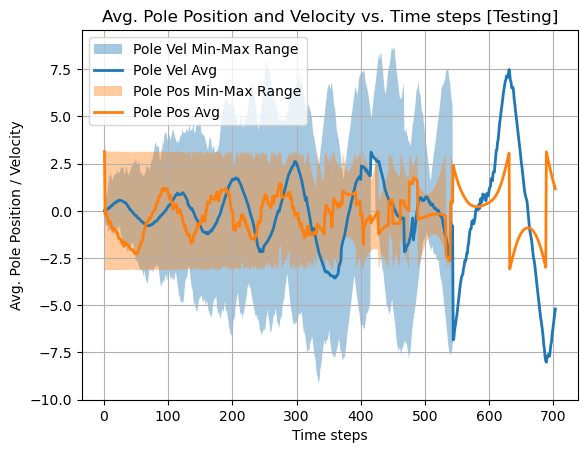

In [11]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(pole_pos_np_min)):
    if pole_pos_np_min[i] == 0:
        pole_pos_np_min[i] = avg_error_pole_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        pole_pos_np_max[i] = avg_error_pole_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(pole_vel_np_min)):
    if pole_vel_np_min[i] == 0:
        pole_vel_np_min[i] = avg_error_pole_vel_dict[i]
    if pole_vel_np_max[i] == 0:
        pole_vel_np_max[i] = avg_error_pole_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array for array in pole_vel_np_min.values()]
y_vel_max = [array for array in pole_vel_np_max.values()]
y_vel_avg = [array for array in avg_error_pole_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Pole Vel Min-Max Range')

# Plot average error for pole velocity
ax.plot(x, y_vel_avg, linewidth=2, label='Pole Vel Avg')

y_pos_min = [array for array in pole_pos_np_min.values()]
y_pos_max = [array for array in pole_pos_np_max.values()]
y_pos_avg = [array for array in avg_error_pole_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Pole Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Pole Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.01)[0]
print("stabilized_index_pos: ", stabilized_index_pos[0])

# Plot dashed line for stabilized region and change its color to red
# if len(stabilized_index_pos) > 0:
#     start_stable = stabilized_index_pos[0]
#     end_stable = stabilized_index_pos[-1]
#     stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
#     stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
#     print("Minimum value in stabilized region:", stabilized_y_min)
#     print("Maximum value in stabilized region:", stabilized_y_max)

#     start_stable = stabilized_index_pos[0]
#     end_stable = stabilized_index_pos[-1]
#     ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

#     # Plot markers for stabilized time steps
#     ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Pole Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Pole Position / Velocity')

# Add legend
ax.legend()

plt.show()

### Graph: Avg.Cart Position and Velocity vs Time steps [Testing] 

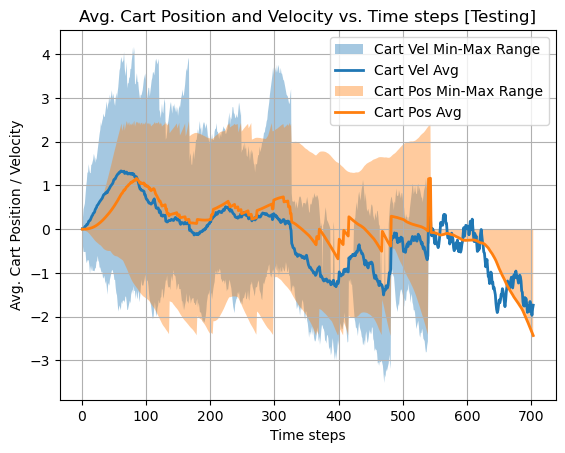

In [16]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(cart_pos_np_min)):
    if cart_pos_np_min[i] == 0:
        cart_pos_np_min[i] = avg_error_cart_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        cart_pos_np_max[i] = avg_error_cart_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(cart_vel_np_min)):
    if cart_vel_np_min[i] == 0:
        cart_vel_np_min[i] = avg_error_cart_vel_dict[i]
    if cart_vel_np_max[i] == 0:
        cart_vel_np_max[i] = avg_error_cart_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array for array in cart_vel_np_min.values()]
y_vel_max = [array for array in cart_vel_np_max.values()]
y_vel_avg = [array for array in avg_error_cart_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Cart Vel Min-Max Range')

# Plot average error for pole velocity
ax.plot(x, y_vel_avg, linewidth=2, label='Cart Vel Avg')

y_pos_min = [array for array in cart_pos_np_min.values()]
y_pos_max = [array for array in cart_pos_np_max.values()]
y_pos_avg = [array for array in avg_error_cart_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Cart Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Cart Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.008)[0]
# print("stabilized_index_cart: ", start_stable)

# Plot dashed line for stabilized region and change its color to red
# if len(stabilized_index_pos) > 0:
#     # start_stable = stabilized_index_pos[0]
#     # end_stable = stabilized_index_pos[-1]
#     stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
#     stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
#     print("Minimum value in stabilized region:", stabilized_y_min)
#     print("Maximum value in stabilized region:", stabilized_y_max)

#     ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

#     # Plot markers for stabilized time steps
#     ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Cart Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Cart Position / Velocity')

# Add legend
ax.legend()

plt.show()